In [1]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

from spec_bin import *
#from lanczos_bin import mystep,distribution

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
class get_hamiltonian():

    def __init__(self,J,Jz,s):
        self.N = len(J)
        self.s = s
        self.J = J
        self.Jz = Jz
        self.dtype = np.float128

        self.M = int(2*self.s+1)
        self.Sx = np.zeros((self.M,self.M),dtype='complex')
        self.Sy = np.zeros((self.M,self.M),dtype='complex')
        self.Sz = np.zeros((self.M,self.M),dtype='complex')
        for i in range(self.M):
            for j in range(self.M):
                self.Sx[i,j] = ((i==j+1)+(i+1==j))*np.sqrt(s*(s+1)-(s-i)*(s-j))/2
                self.Sy[i,j] = ((i+1==j)-(i==j+1))*np.sqrt(s*(s+1)-(s-i)*(s-j))/2j
                self.Sz[i,j] = (i==j)*(s-i)

    def __matmul__(self,v):
                
        if v.ndim == 2:
            m,n = v.shape
        else:
            m = len(v)
            n = 1 
    
        out = np.zeros((m,n),dtype='complex')

        for j in range(self.N):
            if  np.count_nonzero(self.J[:,j]) != 0:
                I1 = self.M**j
                I2 = self.M**(self.N-j-1)
                Sxj_v = ((self.Sx@v.T.reshape(n,I1,-1,I2))).reshape(n,-1).T
                Syj_v = ((self.Sy@v.T.reshape(n,I1,-1,I2))).reshape(n,-1).T
                Szj_v = ((self.Sz@v.T.reshape(n,I1,-1,I2))).reshape(n,-1).T

                # symmetry
                for i in range(j):
                    if self.J[i,j] != 0:
                        I1 = self.M**i
                        I2 = self.M**(self.N-i-1)
                        Sxi_Sxj_v = ((self.Sx@Sxj_v.T.reshape(n,I1,-1,I2))).reshape(n,-1).T
                        Syi_Syj_v = ((self.Sy@Syj_v.T.reshape(n,I1,-1,I2))).reshape(n,-1).T

                        out += (2-(i==j))*self.J[i,j] * ( Sxi_Sxj_v + Syi_Syj_v )

                out += self.Jz[j] * Szj_v
            
        return out.flatten() if n==1 else out
    
    def tosparse(self):
                
        out = sp.sparse.coo_matrix((self.M**self.N,self.M**self.N),dtype='complex')

        for j in range(self.N):
            if  np.count_nonzero(self.J[:,j]) != 0:
                I1 = sp.sparse.eye(self.M**j,dtype='complex')
                I2 = sp.sparse.eye(self.M**(self.N-j-1),dtype='complex')
                Sxj = sp.sparse.kron(sp.sparse.kron(I1,self.Sx),I2)
                Syj = sp.sparse.kron(sp.sparse.kron(I1,self.Sy),I2)
                Szj = sp.sparse.kron(sp.sparse.kron(I1,self.Sz),I2)

                for i in range(j):
                    if self.J[i,j] != 0:
                        I1 = sp.sparse.eye(self.M**i,dtype='complex')
                        I2 = sp.sparse.eye(self.M**(self.N-i-1),dtype='complex')
                        Sxi_Sxj = sp.sparse.kron(sp.sparse.kron(I1,self.Sx),I2)@Sxj
                        Syi_Syj = sp.sparse.kron(sp.sparse.kron(I1,self.Sy),I2)@Syj
                        #Szi_Szj = sp.sparse.kron(sp.sparse.kron(I1,self.Sz),I2)@Szj

                        out += (2-(i==j))*self.J[i,j] * ( Sxi_Sxj + Syi_Syj )

                out += self.Jz[j] * Szj
            
        return out

In [4]:
N = 12
s = 1/2
n = int((2*s+1)**N)

In [5]:
J = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        J[i,j] = ((i-j)%N==1) + ((j-i)%N==1)

In [6]:
H_mf = get_hamiltonian(J,np.zeros(N),s).tosparse()

In [7]:
λ=np.linalg.eigvalsh(H_mf.A)

In [8]:
nv = 300
k_max = 50

np.random.seed(0)
v = np.random.randn(n,nv)
v /= np.linalg.norm(v,axis=0)

(αL,βL) = lanczos_block(H_mf,v,k_max,verbose=True)

iter=49


In [9]:
k = k_max

θ_gq = np.full((nv,k),np.nan)
ω_gq = np.full((nv,k),np.nan)

for j in range(nv):
    θ_gq[j],ω_gq[j] = get_gq(k,αL[:,j],βL[:,j])
    
θ_gq_ave = θ_gq.reshape(-1)
ω_gq_ave = ω_gq.reshape(-1)/nv

In [10]:
a,b = np.min(θ_gq),np.max(θ_gq)

αT = np.ones(2*k_max+1)*(a+b)/2
βT = np.ones(2*k_max+1)*(b-a)/4
βT[0] *= np.sqrt(2)

m = np.full((nv,2*k+1),np.nan)

for j in range(nv):
    m[j] = get_moments_from_lanczos(H_mf,v,2*k_max,αT,βT,T=(αL[:,j],βL[:,j]))

θ_iq = np.full((nv,2*k+1),np.nan)
ω_iq = np.full((nv,2*k+1),np.nan)
θ_diq = np.full((nv,2*k+1),np.nan)
ω_diq = np.full((nv,2*k+1),np.nan)

ρ = jackson_weights(2*k+1)
for j in range(nv):
    θ_iq[j],ω_iq[j] = get_iq(m[j],2*k,αT,βT)
    θ_diq[j],ω_diq[j] = get_iq(m[j]*ρ,2*k,αT,βT)
    
θ_iq_ave = np.mean(θ_iq,axis=0)
ω_iq_ave = np.mean(ω_iq,axis=0)
θ_diq_ave = np.mean(θ_diq,axis=0)
ω_diq_ave = np.mean(ω_diq,axis=0)

In [11]:
def C_kB(β,θ,ω,offset=0):
    
    return β**2*( ( ω@(θ**2*np.exp(-β*(θ-offset))) ) / ( ω@(np.exp(-β*(θ-offset))) ) \
                - ( ( ω@(θ*np.exp(-β*(θ-offset))) )    / ( ω@(np.exp(-β*(θ-offset))) ) )**2)

n_β = 500

kBT = np.logspace(-5,2,n_β)
β = 1/kBT

C_kB_ED = np.full(n_β,np.nan)

C_kB_gq_ave = np.full(n_β,np.nan)
C_kB_iq_ave = np.full(n_β,np.nan)
C_kB_diq_ave = np.full(n_β,np.nan)
for i in range(n_β):
    with np.errstate(over='ignore', invalid='ignore'):
        C_kB_ED[i] = C_kB(β[i],λ,np.ones(n)/n,θ_gq_ave[0])
        C_kB_gq_ave[i] = C_kB(β[i],θ_gq_ave,ω_gq_ave,θ_gq_ave[0])
        C_kB_iq_ave[i] = C_kB(β[i],θ_iq_ave,ω_iq_ave,θ_gq_ave[0])
        C_kB_diq_ave[i] = C_kB(β[i],θ_diq_ave,ω_diq_ave,θ_gq_ave[0])

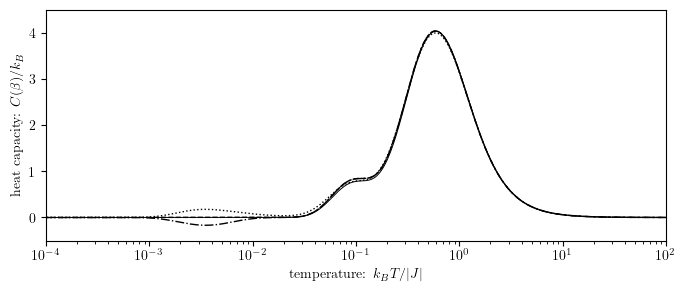

In [12]:
plt.subplots(figsize=(8,3))

plt.plot(kBT,C_kB_ED,label='ed',color='k',lw=.7)

plt.plot(kBT,C_kB_gq_ave,label='gq',color='k',ls='--',lw=1)
plt.plot(kBT,C_kB_iq_ave,label='iq',color='k',ls='-.',lw=1)
plt.plot(kBT,C_kB_diq_ave,label='diq',color='k',ls=':',lw=1)

plt.xscale('log')
#plt.legend()

plt.ylabel(r'heat capacity: $C(\beta)/k_B$')
plt.xlabel(r'temperature: $k_B T/|J|$')
plt.xlim(1e-4,1e2)
plt.ylim(-.5,4.5)

plt.savefig('imgs/spin_heat_capacity.pdf',bbox_inches='tight')